In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path().resolve().parent))

# import better_exceptions
from scikit_quri.qnn.regressor import QNNRegressor
import numpy as np
from numpy.random import default_rng

from quri_parts.core.operator import Operator, pauli_label
from quri_parts.core.estimator.gradient import create_numerical_gradient_estimator
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_concurrent_parametric_estimator,
    create_qulacs_vector_concurrent_estimator,
)
from quri_parts.algo.optimizer import Adam
from scikit_quri.circuit.pre_defined import create_qcl_ansatz


def generate_noisy_sine(x_min, x_max, num_x):
    rng = default_rng(0)
    x_train = [[rng.uniform(x_min, x_max)] for _ in range(num_x)]
    y_train = [np.sin(np.pi * x[0]) for x in x_train]
    mag_noise = 0.01
    y_train += mag_noise * rng.random(num_x)
    # return np.array(x_train), np.array(y_train)
    return np.array(x_train).flatten(), np.array(y_train)


x_train, y_train = generate_noisy_sine(-1.0, 1.0, 80)
x_test, y_test = generate_noisy_sine(-1.0, 1.0, 80)

In [2]:
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
import matplotlib.pyplot as plt

n_qubits = 5
depth = 6
n_outputs = 1
parametric_circuit = create_qcl_ansatz(n_qubits, depth, 0.5, 0)

ops = []
for i in range(n_outputs):
    op = Operator({pauli_label(f"Z {i}"): 1.0})
    ops.append(op)
draw_circuit(parametric_circuit.circuit)

estimator = create_qulacs_vector_concurrent_estimator()
gradient_estimator = create_numerical_gradient_estimator(
    create_qulacs_vector_concurrent_parametric_estimator(), delta=1e-10
)
adam = Adam()

   ___     ___     ___     ___     ___     ___     ___     ___     ___     ___  
  |PRY|   |PRZ|   |Mat|   |PRX|   |PRZ|   |PRX|   |Mat|   |PRX|   |PRZ|   |PRX| 
--|0  |---|1  |---|10 |---|11 |---|12 |---|13 |---|26 |---|27 |---|28 |---|29 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|2  |---|3  |---|   |---|14 |---|15 |---|16 |---|   |---|30 |---|31 |---|32 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|4  |---|5  |---|   |---|17 |---|18 |---|19 |---|   |---|33 |---|34 |---|35 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    _

In [3]:
init_params = 2 * np.pi * np.random.rand(parametric_circuit.learning_params_count)

In [4]:
qnn = QNNRegressor(n_qubits, parametric_circuit, estimator, gradient_estimator, adam, ops)

qnn.fit(x_train, y_train, maxiter=30)

init_params=array([5.57759062e+00, 1.44689350e+00, 1.24230153e+00, 1.48472250e-01,
       5.33916124e+00, 3.06264504e+00, 1.11321547e+00, 4.97880142e+00,
       2.58772975e+00, 6.14894998e+00, 9.86362102e-01, 1.82769758e+00,
       2.78158526e+00, 2.65136457e+00, 2.95650294e+00, 1.62214959e+00,
       7.89133129e-01, 5.64585972e-01, 4.72478174e+00, 5.49905269e+00,
       5.94865948e+00, 1.26863157e+00, 7.03299645e-02, 1.59489121e+00,
       2.03253012e+00, 3.38045229e+00, 5.97667035e+00, 1.01500135e+00,
       2.60094587e+00, 6.11286906e+00, 2.72270590e+00, 7.70050035e-01,
       3.61108756e+00, 3.06365465e+00, 3.15293951e+00, 5.59281490e+00,
       2.77402558e+00, 6.70475821e-01, 4.52536789e+00, 1.71478912e+00,
       2.21836546e+00, 6.24132186e+00, 3.77197562e+00, 3.21794438e+00,
       4.32309147e+00, 5.72817017e+00, 4.91702701e-01, 4.68780223e+00,
       6.00227797e+00, 2.21065525e-01, 4.10186879e-01, 3.19285711e+00,
       4.02570381e+00, 2.42213215e+00, 1.06057045e+00, 5.73706940

loss=0.00911069070701968


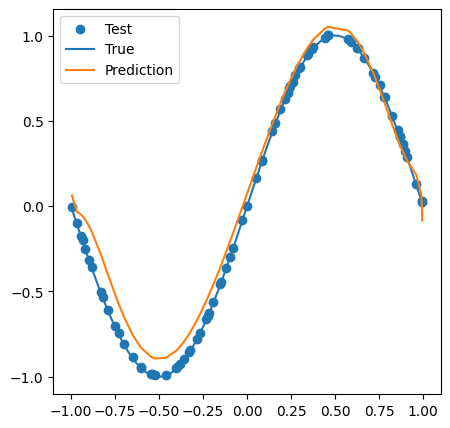

In [5]:
y_pred = qnn.predict(x_test)
y_test = y_test.reshape(-1, 1)
plt.figure(figsize=(5, 5))

plt.scatter(np.sort(x_test.flatten()), y_test[np.argsort(x_test.flatten())], label="Test")

x_true = np.linspace(-1, 1, 100)
y_true = np.sin(np.pi * x_true)
plt.plot(x_true, y_true, label="True")
plt.plot(np.sort(x_test.flatten()), y_pred[np.argsort(x_test.flatten())], label="Prediction")
plt.legend()

from sklearn.metrics import mean_squared_error

loss = mean_squared_error(y_test, y_pred)
print(f"{loss=}")
plt.show()